# MCMC na modelagem da variação diária do dólar americano em 2020

notebook fortemente baseado em https://github.com/Joseph94m/MCMC

In [1]:
import numpy as np
import scipy #acho q a gnt nem usa scipy 
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import math
%matplotlib inline

### pegando os dados para visualizar:

In [2]:
cot=np.genfromtxt('cotacao2.csv', delimiter=';') #planilha no excel com os dados

Text(0.5, 1.0, 'Figura 1: diferença dia a dia')

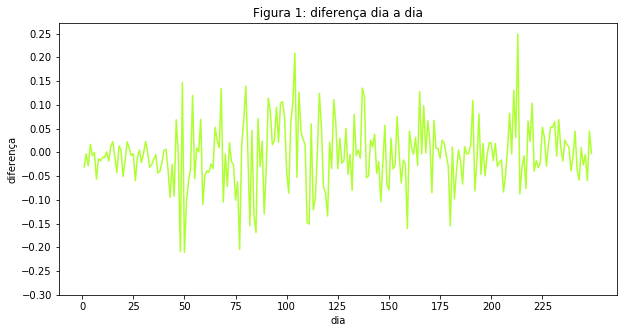

In [3]:
#dias na quinta coluna
dias = cot[2:,4]
#dif compra na sexta coluna
dif = cot[2:,5]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

ax.plot(dias, dif, color='greenyellow', label="Diferença do preço de compra do dólar dia a dia")
ax.set_yticks(np.arange(-0.3,0.3,0.05)) #intervalo do eixo y e de quanto em quanto vão as marcações
ax.set_xticks(np.arange(0,248,25)) #intervalo do eixo x e de quanto em quanto vão as marcações
ax.set_xlabel("dia")
ax.set_ylabel("diferença")
ax.set_title("Figura 1: diferença dia a dia")

Text(0.5, 1.0, 'Figura 2: Histograma das frequências de variações diárias em intervalos')

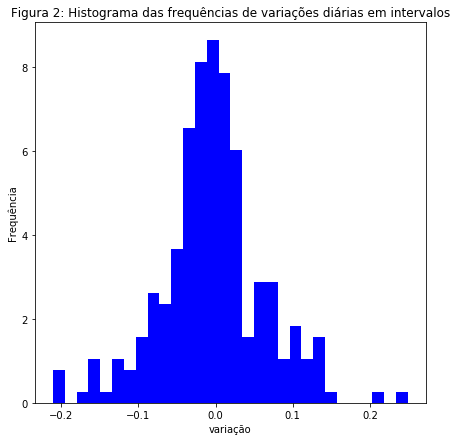

In [4]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.hist(dif, bins=30, density=True, color="blue") #faz um histograma com 30 intervalos de valores
ax.set_xlabel("variação")
ax.set_ylabel("Frequência")
ax.set_title("Figura 2: Histograma das frequências de variações diárias em intervalos")

## vou modelar como uma Normal


### aqui defino o método de transição, priori e log verossimilhança

In [5]:
transitor = lambda p: np.random.normal(p,[0.005,0.005],2)
#atualiza o (mu,de) tomando para cada um valor retirado de uma dist normal cm média mu/de e variancia 0.025


def priori(p): #aqui poderia ser uma função de densidade de probbilidade clássica, mas preferi não complicar mais no momento 
    if(p[1] <=0): 
        return 0 #porque não queremos variância negativa; isso é inviável pra normal
    else:
        return 1 #provavelmente deveria ser um outro número aqui... mas isso seria apenas uma constante multiplicativa no fim
    
def manual_log_ver_normal(p,data):
    return np.sum(-np.log(abs(p[1]))-((1/2)*(data-p[0])/p[1])**2) #a log_verossimilhança de uma normal com média p[0] e var p[1]
    
def aceita(p, p_new): #p_new é a ver para os parâmetros novos menos a ver para os parâmetros antigos (elas já entram exponenciadas, então ver não log_ver)
    if p_new>p: #se a ver for maior pro x atualizado, vamos querer usar ele 
        return True
    else: #se não, entra o fator Monte Carolo, que aceita com uma certa probabilidade
        accept=np.random.uniform(0,1)
        return (accept < (p_new/p))
        #p_new/p é uma probabilidade (acho que mais algo como chance/odd na verdade)

### aqui implemento o Metropolis Hastings

In [6]:
                    #manual_log_lik_normal  prior  atualização       inits      iterações  dados aceita 
def metropolis_hastings(log_ver, priori, transitor, inits, iterações, data, regra_aceita):
    # log_ver(p,data): retorna a log_ver dos parâmetros p pros dados data 
    # transitor(p): retorna parâmetros próximos dos parâmetros dados p
    # inits: chute inicial
    # iterações: o número de atualizações que serão feitas
    # data: os dados kkkk
    # aceita(p,p_new): retorna 0 se o p_new é rejeitado e 1 se não
    
    p = inits
    aceitos = [] #parâmetros que serão aceitos
    rejeitos= [] #parâmetros rejeitados
    completo= [] #todo o trajeto
    for i in range(iterações):
        p_new =  transitor(p)    
        p_lik = log_ver(p,data)
        p_new_lik = log_ver(p_new,data) 
        if (aceita(np.exp(p_lik)*priori(p),np.exp(p_new_lik)*priori(p_new))):            
            p = p_new
            aceitos.append(p_new)
            completo.append(p_new)
        else:
            rejeitos.append(p_new)
            completo.append(p_new)
            completo.append(p)
    return np.array(aceitos), np.array(rejeitos), np.array(completo)

### chamando e plotando resultados

In [7]:
aceitos, rejeitos ,completo = metropolis_hastings(manual_log_ver_normal,priori,transitor,[1,2], 5000,dif,aceita)

In [8]:
aceitos[-1]

array([0.0008005 , 0.04650679])

Text(0.5, 1.0, 'Figura 5: tudo')

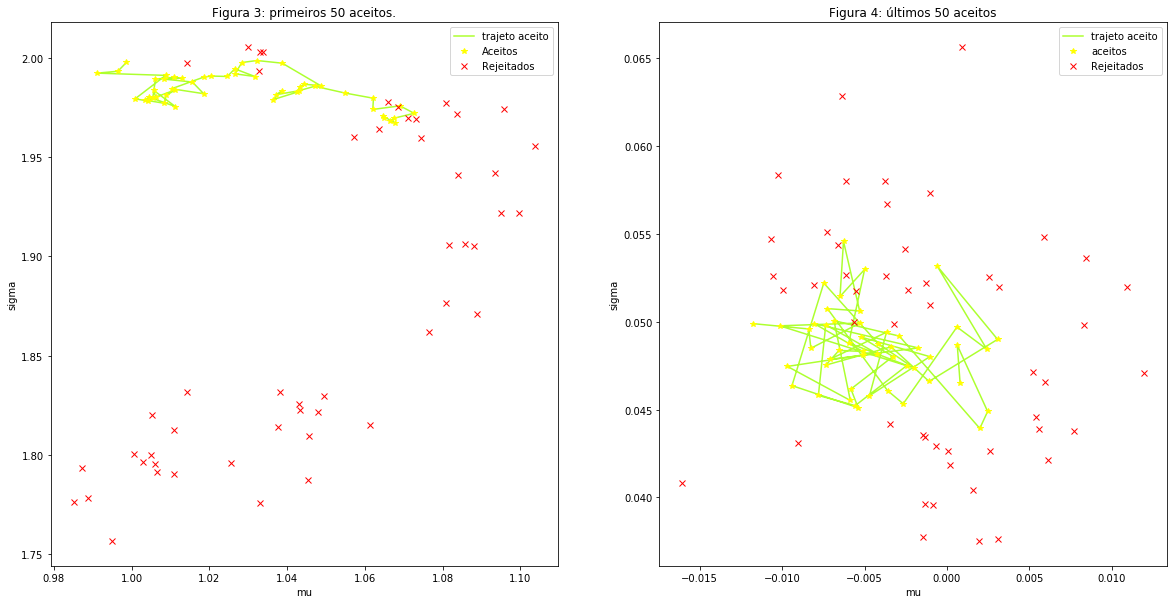

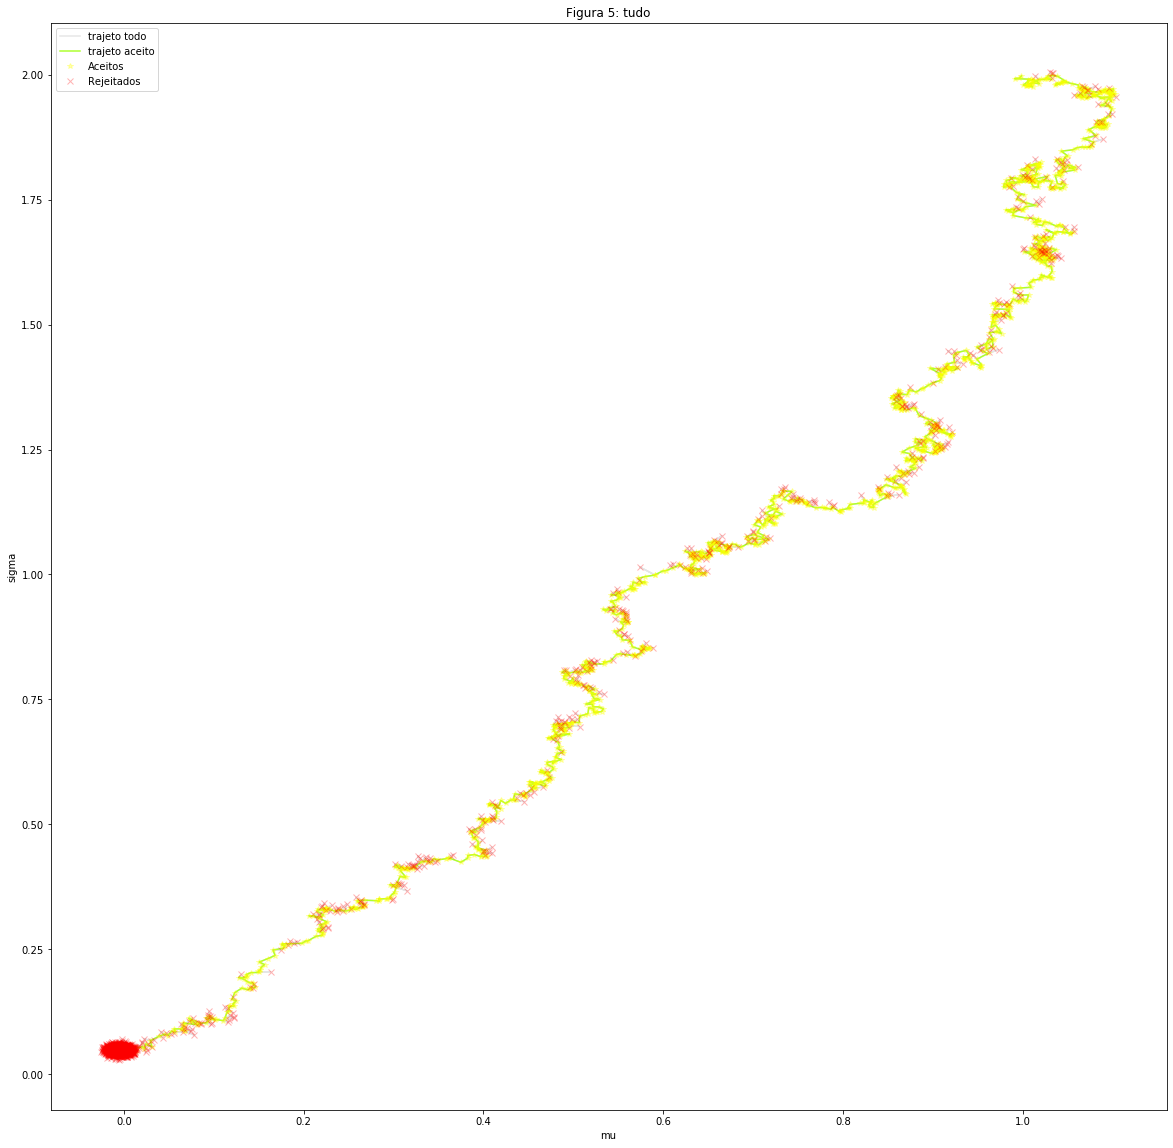

In [9]:
fig1 = plt.figure(figsize=(20,10))
ax = fig1.add_subplot(1,2,1)
ax.plot(aceitos[:50,0], aceitos[:50,1],color='greenyellow', label="trajeto aceito")
ax.plot(aceitos[:50,0], aceitos[:50,1], '*', label='Aceitos',color='yellow')
ax.plot(rejeitos[:50,0], rejeitos[:50,1], 'rx', label='Rejeitados')
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.legend()
ax.set_title("Figura 3: primeiros 50 aceitos.")  

ax = fig1.add_subplot(1,2,2)
ax.plot(aceitos[-50:,0], aceitos[-50:,1], label="trajeto aceito", color='greenyellow')
ax.plot(aceitos[-50:,0], aceitos[-50:,1], '*', label='aceitos',color='yellow')
ax.plot(rejeitos[-50:,0], rejeitos[-50:,1], 'rx', label='Rejeitados')
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.legend()
ax.set_title("Figura 4: últimos 50 aceitos") 




fig2=plt.figure(figsize=(20,20))
ax = fig2.add_subplot(1,1,1)
ax.plot(completo[:,0], completo[:,1], label="trajeto todo", color="gray", alpha=0.2)
ax.plot(aceitos[:,0], aceitos[:,1], label="trajeto aceito", color='greenyellow')
ax.plot(aceitos[:,0], aceitos[:,1], '*', label='Aceitos',color='yellow',alpha=0.3)
ax.plot(rejeitos[:,0], rejeitos[:,1], 'rx', label='Rejeitados',alpha=0.3)
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.legend()
ax.set_title("Figura 5: tudo")

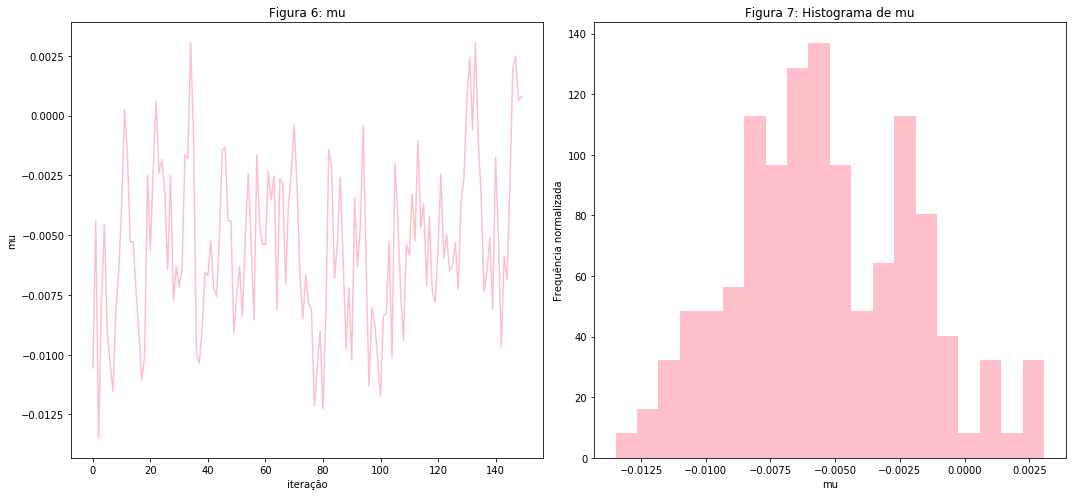

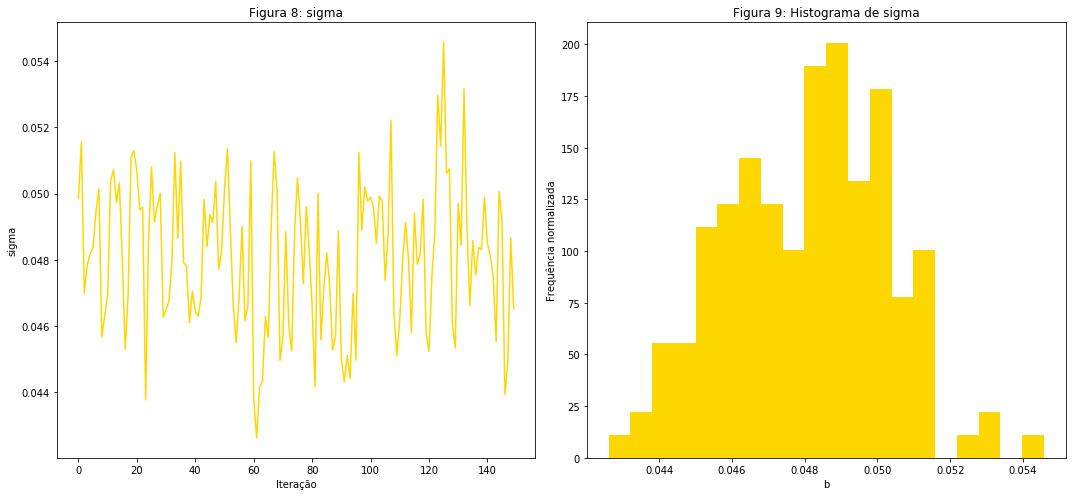

In [10]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(aceitos[-150:,0], color="pink")
ax.set_title("Figura 6: mu")
ax.set_xlabel("iteração")
ax.set_ylabel("mu")
ax = fig.add_subplot(1,2,2)
ax.hist(aceitos[-150:,0], bins=20, density=True, color="pink")
ax.set_ylabel("Frequência normalizada")
ax.set_xlabel("mu")
ax.set_title("Figura 7: Histograma de mu")
fig.tight_layout()

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(aceitos[-150:,1], color="gold")
ax.set_title("Figura 8: sigma")
ax.set_xlabel("Iteração")
ax.set_ylabel("sigma")
ax = fig.add_subplot(1,2,2)
ax.hist(aceitos[-150:,1], bins=20, density=True, color="gold")
ax.set_ylabel("Frequência normalizada")
ax.set_xlabel("b")
ax.set_title("Figura 9: Histograma de sigma")
fig.tight_layout()

Text(0.5, 1.0, 'figura 10:distribuição conjunta de mu e sigma')

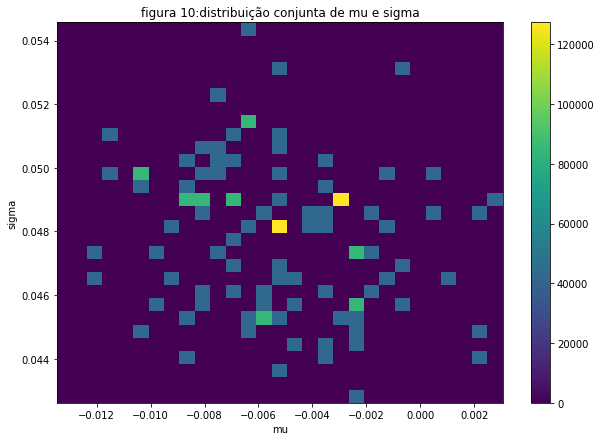

In [11]:
max_mu=max(aceitos[-150:,0])
min_mu=min(aceitos[-150:,0])
max_sig=max(aceitos[-150:,1])
min_sig=min(aceitos[-150:,1])

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
xbins, ybins = np.linspace(min_mu,max_mu,30), np.linspace(min_sig,max_sig,30)
counts, xedges, yedges, im = ax.hist2d(aceitos[-100:,0], aceitos[-100:,1], density=True, bins=[xbins, ybins])
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
fig.colorbar(im, ax=ax)
ax.set_title("figura 10:distribuição conjunta de mu e sigma")


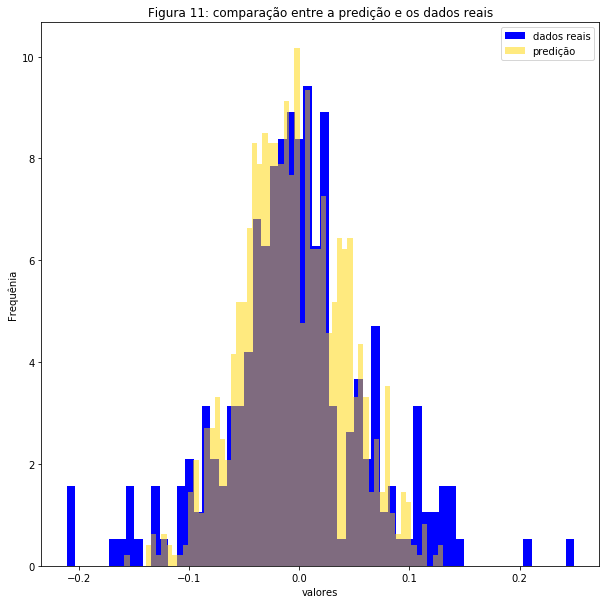

In [12]:
mu=aceitos[-50:,0].mean() #média dos 150 últimos
sigma=aceitos[-50:,1].mean() #média dos 150 últimos
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t) 
t=np.array([1]*1000)
observation_gen=model(t.shape[0],mu,sigma) #faz uma simulação com os valores estimados
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

ax.hist( dif,bins=60 , color="blue",density=True, label="dados reais")
ax.hist( observation_gen,bins=60, color="gold",alpha=0.5,density=True,label="predição")
ax.set_xlabel("valores")
ax.set_ylabel("Frequênia")
ax.set_title("Figura 11: comparação entre a predição e os dados reais")
ax.legend()

### defini outro método de transição, para ver se conseguia um resultado melhor

In [13]:
trans_seq_cauchy = lambda x, t: np.random.normal(x,[1.005**(-t),1.005**(-t)],2)

In [14]:
                    #manual_log_lik_normal  prior  atualização       inits      iterações  dados aceita 
def metropolis_hastings(log_ver, priori, transitor, inits, iterações, data, regra_aceita):
    # log_ver(p,data): retorna a log_ver dos parâmetros p pros dados data 
    # transitor(p): retorna parâmetros próximos dos parâmetros dados p
    # inits: chute inicial
    # iterações: o número de atualizações que serão feitas
    # data: os dados kkkk
    # aceita(p,p_new): retorna 0 se o p_new é rejeitado e 1 se não
    
    p = inits
    aceitos = [] #parâmetros que serão aceitos
    rejeitos= [] #parâmetros rejeitados
    completo= [] #todo o trajeto
    for i in range(iterações):
        p_new =  transitor(p,i)    
        p_lik = log_ver(p,data)
        p_new_lik = log_ver(p_new,data) 
        if (aceita(np.exp(p_lik)*priori(p),np.exp(p_new_lik)*priori(p_new))):            
            p = p_new
            aceitos.append(p_new)
            completo.append(p_new)
        else:
            rejeitos.append(p_new)
            completo.append(p_new)
            completo.append(p)
    return np.array(aceitos), np.array(rejeitos), np.array(completo)

### de novo, chamando e plotando resultados

In [15]:
aceitos, rejeitos, completo = metropolis_hastings(manual_log_ver_normal, priori, trans_seq_cauchy, [7,12], 2000, dif,aceita)

In [16]:
aceitos[-1]

array([-0.00632395,  0.04893912])

Text(0.5, 1.0, 'Figura 14: tudo')

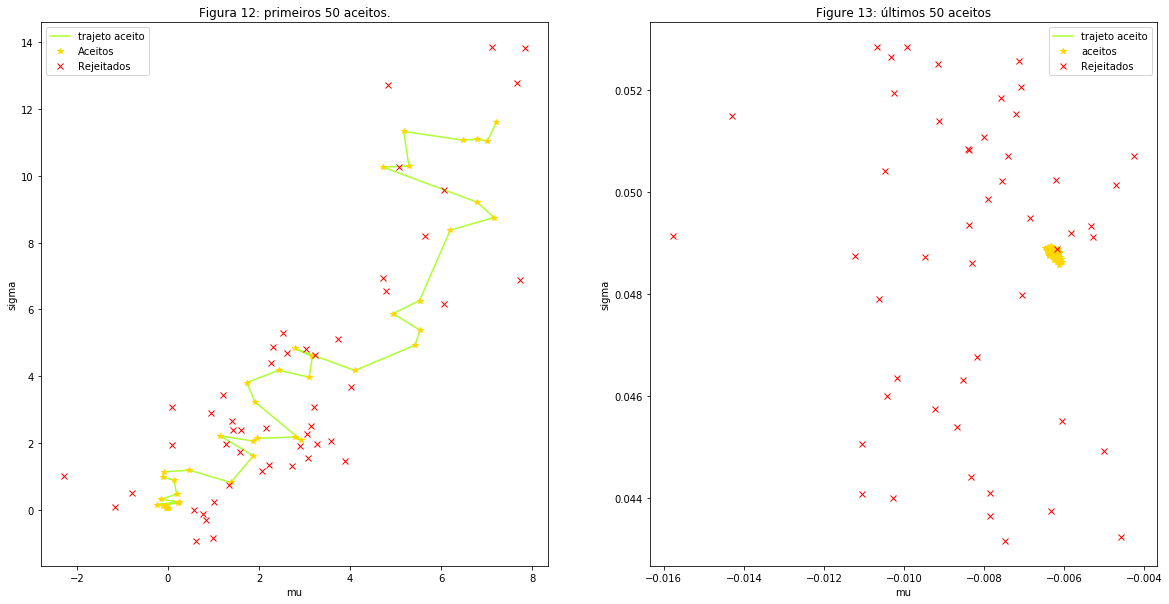

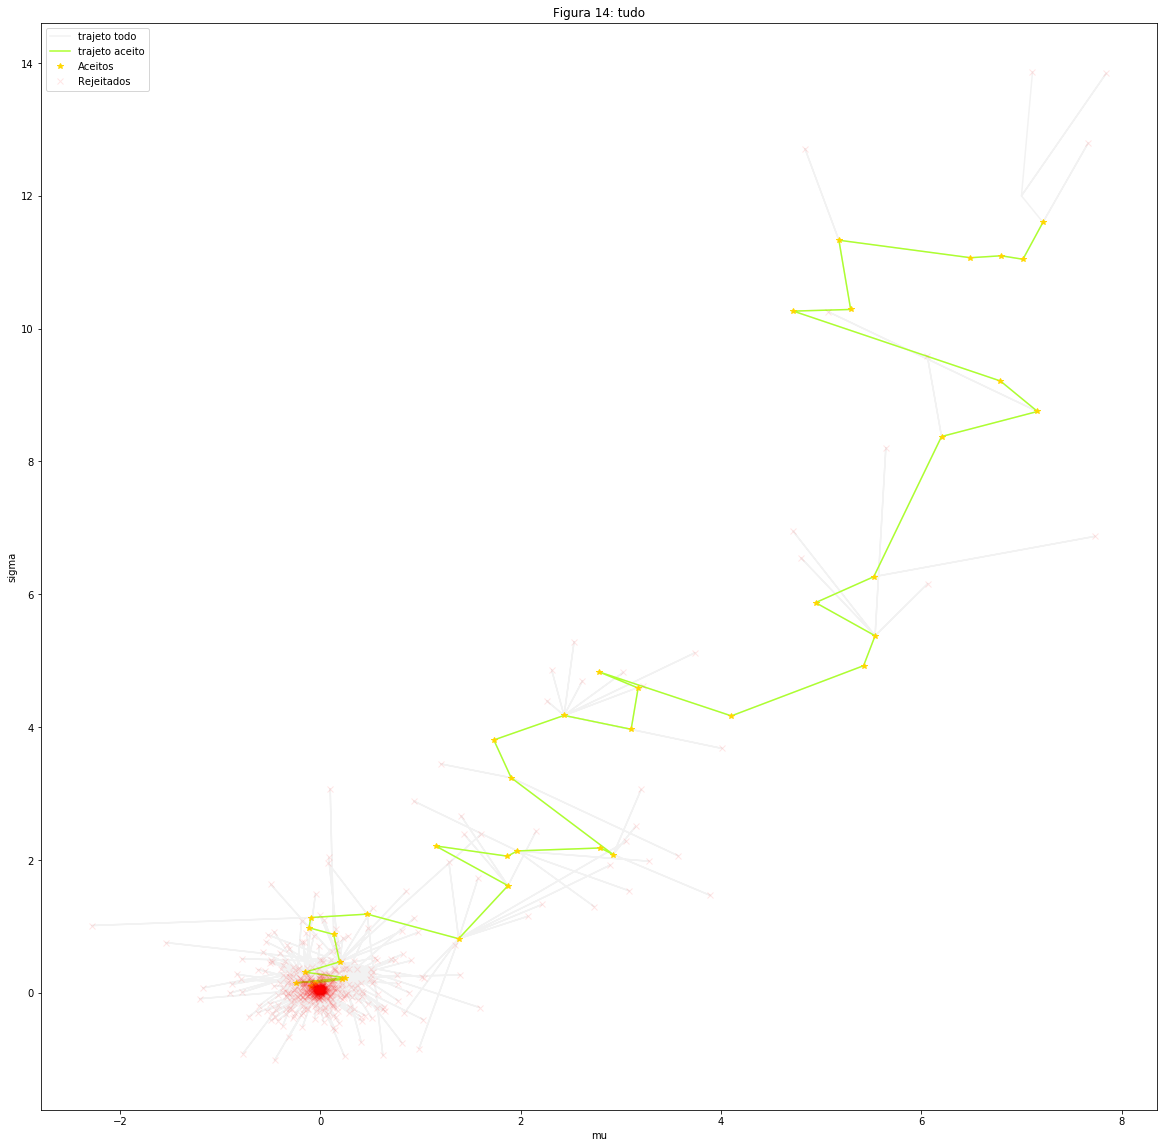

In [17]:
fig1 = plt.figure(figsize=(20,10))
ax = fig1.add_subplot(1,2,1)
ax.plot(aceitos[:50,0], aceitos[:50,1],color='greenyellow', label="trajeto aceito")
ax.plot(aceitos[:50,0], aceitos[:50,1], '*', label='Aceitos',color='gold')
ax.plot(rejeitos[:50,0], rejeitos[:50,1], 'rx', label='Rejeitados')
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.legend()
ax.set_title("Figura 12: primeiros 50 aceitos.")  

ax = fig1.add_subplot(1,2,2)
ax.plot(aceitos[-50:,0], aceitos[-50:,1], label="trajeto aceito", color='greenyellow')
ax.plot(aceitos[-50:,0], aceitos[-50:,1], '*', label='aceitos',color='gold')
ax.plot(rejeitos[-50:,0], rejeitos[-50:,1], 'rx', label='Rejeitados')
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.legend()
ax.set_title("Figure 13: últimos 50 aceitos") 




fig2=plt.figure(figsize=(20,20))
ax = fig2.add_subplot(1,1,1)
ax.plot(completo[:,0], completo[:,1], label="trajeto todo", color="gray", alpha=0.1)
ax.plot(aceitos[:,0], aceitos[:,1], label="trajeto aceito", color='greenyellow')
ax.plot(aceitos[:,0], aceitos[:,1], '*', label='Aceitos',color='gold')
ax.plot(rejeitos[:,0], rejeitos[:,1], 'rx', label='Rejeitados',alpha=0.1)
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.legend()
ax.set_title("Figura 14: tudo")

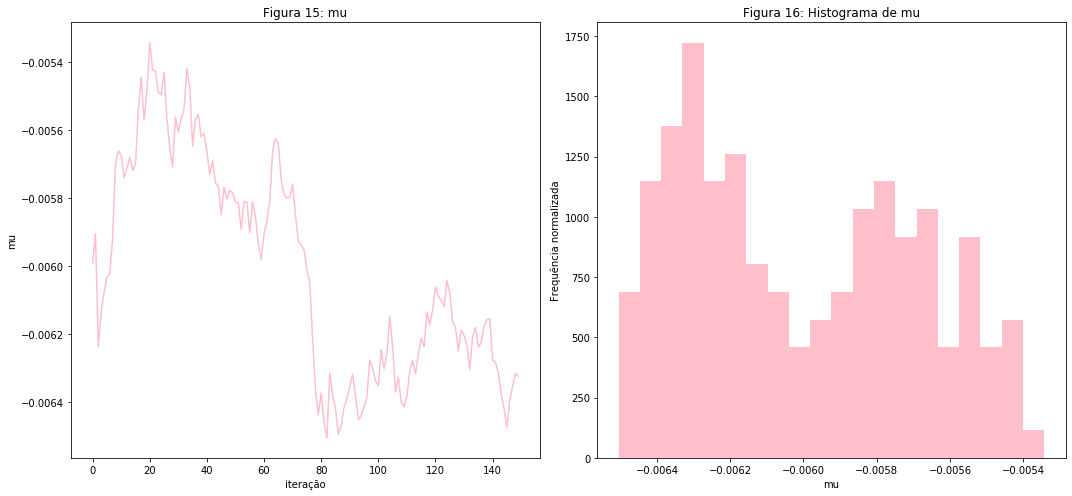

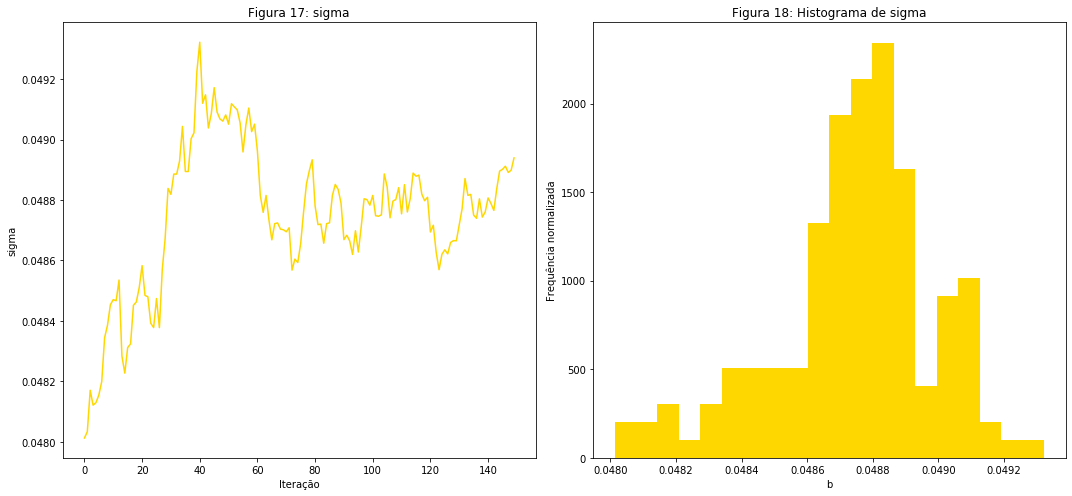

In [18]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(aceitos[-150:,0], color="pink")
ax.set_title("Figura 15: mu")
ax.set_xlabel("iteração")
ax.set_ylabel("mu")
ax = fig.add_subplot(1,2,2)
ax.hist(aceitos[-150:,0], bins=20, density=True, color="pink")
ax.set_ylabel("Frequência normalizada")
ax.set_xlabel("mu")
ax.set_title("Figura 16: Histograma de mu")
fig.tight_layout()

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(aceitos[-150:,1], color="gold")
ax.set_title("Figura 17: sigma")
ax.set_xlabel("Iteração")
ax.set_ylabel("sigma")
ax = fig.add_subplot(1,2,2)
ax.hist(aceitos[-150:,1], bins=20, density=True, color="gold")
ax.set_ylabel("Frequência normalizada")
ax.set_xlabel("b")
ax.set_title("Figura 18: Histograma de sigma")
fig.tight_layout()

Text(0.5, 1.0, 'Figura 19: distribuição conjunta de mu e sigma')

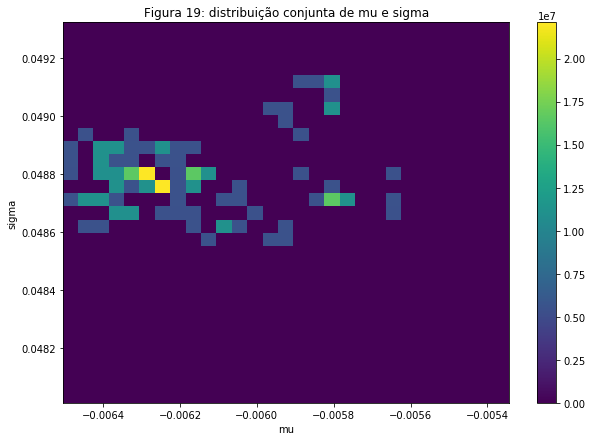

In [19]:
max_mu=max(aceitos[-150:,0])
min_mu=min(aceitos[-150:,0])
max_sig=max(aceitos[-150:,1])
min_sig=min(aceitos[-150:,1])

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
xbins, ybins = np.linspace(min_mu,max_mu,30), np.linspace(min_sig,max_sig,30)
counts, xedges, yedges, im = ax.hist2d(aceitos[-100:,0], aceitos[-100:,1], density=True, bins=[xbins, ybins])
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
fig.colorbar(im, ax=ax)
ax.set_title("Figura 19: distribuição conjunta de mu e sigma")


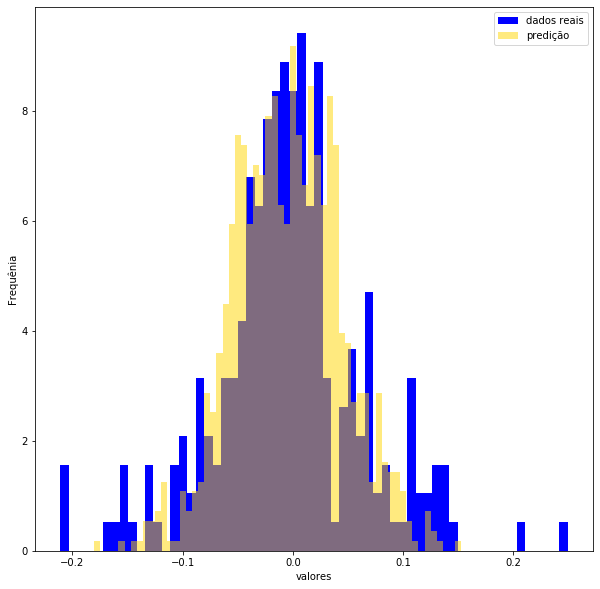

In [20]:
mu=aceitos[-10:,0].mean() #média dos 150 últimos
sigma=aceitos[-10:,1].mean() #média dos 150 últimos
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t) 
t=np.array([1]*1000)
observation_gen=model(t.shape[0],mu,sigma) #faz uma simulação com os valores estimados
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

ax.hist( dif,bins=60 , color="blue",density=True, label="dados reais")
ax.hist( observation_gen,bins=60, color="gold",alpha=0.5,density=True,label="predição")
ax.set_xlabel("valores")
ax.set_ylabel("Frequênia")
#ax.set_title("Figura 20: comparação entre a predição e os dados reais observados")
ax.legend()

# fim
